In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss
from deeponet import DeepONet
from gru2 import GRUModel

(5000, 50, 1)


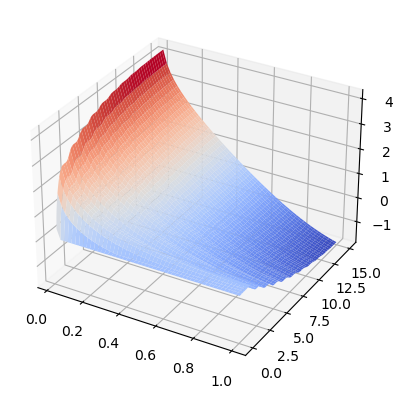

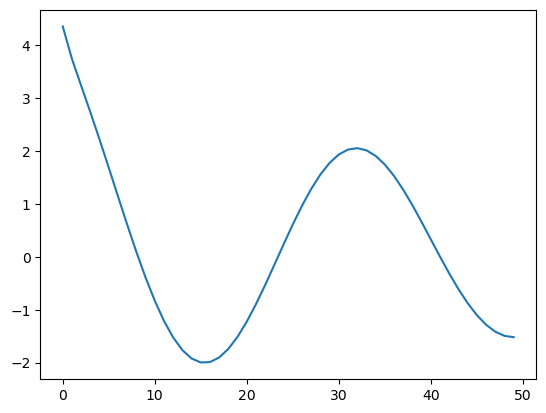

In [2]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)



for i in range(npoints):
    for j in range(int(nt/sampleRate)):
        for k in range(nx):
            xArr[i*int(nt/sampleRate)+j] = x[i, int(j*sampleRate), :]
            yArr[i*int(nt/sampleRate)+j] = y[i, int(j*sampleRate), :]
x=xArr.reshape((npoints*int(nt/sampleRate), nx, 1))
y=yArr.reshape((npoints*int(nt/sampleRate), nx, 1))

plt.figure()
plt.plot(xArr[28])
print(x.shape)
#plt.figure()
#plt.plot(y[0])

In [3]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
branch = nn.Sequential(
    GRUModel(200, 1, 64))

trunk = nn.Sequential(
          nn.Linear(1, 32),
          nn.ReLU(),
          nn.Linear(32,64),
          nn.ReLU()
)
print(branch)
print(trunk)

Sequential(
  (0): GRUModel(
    (gru): GRU(1, 200, batch_first=True)
    (fc): Linear(in_features=200, out_features=64, bias=True)
  )
)
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
)


In [4]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100

In [5]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

grid_repeated = []
x = np.linspace(0, L, nx, dtype=np.float32)
for i in range(batch_size):
    grid_repeated.append(x)
grid_repeated = torch.from_numpy(np.array(grid_repeated).reshape((batch_size, nx, 1))).cuda()
print(grid_repeated.shape)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

torch.Size([20, 50, 1])


In [6]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [7]:
model = DeepONet(branch, trunk).cuda()
print(count_params(model))

136840


In [8]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [9]:
t = default_timer()
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x, grid_repeated)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x, grid_repeated)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)


0 0.9692896110936999 0.35904776877827116 0.17737863570451737
50 0.6236565941944718 0.020124578459395304 0.034646308943629266
100 0.624093874823302 0.009009333590252532 0.007427519988268614
150 0.624727965798229 0.009270638926989502 0.00968438945710659
200 0.6301448070444167 0.005963399679296546 0.0059359950199723245
250 0.6259991829283535 0.005200178786698315 0.0057549262605607505
300 0.6271453108638525 0.003607703440098299 0.003114044414833188
350 0.6317996759898961 0.0033469092049118543 0.005030762739479542
400 0.5702393972314894 0.002552840694681638 0.0025562806194648147
450 0.6301590758375823 0.002375902150136729 0.0023619617614895104
500 0.6222193450666964 0.0020786336747308574 0.0019247157173231243
550 0.6308845579624176 0.002029890844391452 0.0022986289812251927
600 0.625613413285464 0.0017795221171238355 0.0017990276403725147
650 0.5745126446709037 0.0017622971529554989 0.001686766860075295
700 0.6284956391900778 0.0016724548468159304 0.0017048431746661662
750 0.566586685832589

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


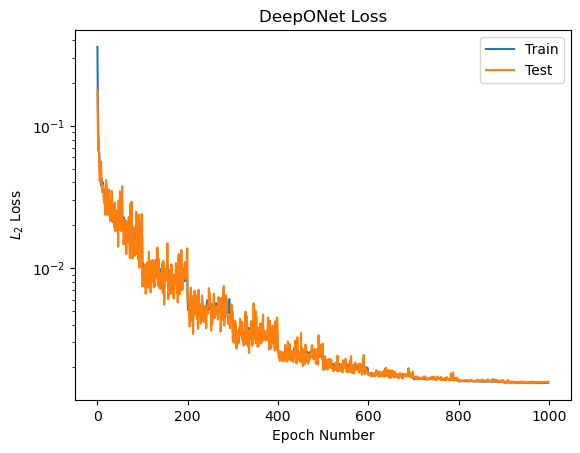

In [17]:
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.title("DeepONet Loss")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig("deeponet.eps")

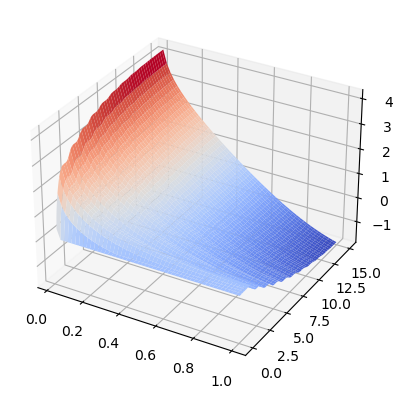

In [18]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)


In [19]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 12
width = 64

In [20]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [25]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        outTensor = torch.from_numpy(np.zeros((batch_size, x.shape[1], x.shape[2]), dtype=np.float32)).cuda()
        for timeStep in range(x.shape[1]):
            out = model(x[:, timeStep, :].reshape(batch_size, x.shape[2], 1), grid_repeated)
            outTensor[:, timeStep, :] = out.reshape(batch_size, x.shape[2])

        test_mse += loss(outTensor, y).item()
print("TEST MSE For " + str(batch_size) + " Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.0030652375891804693


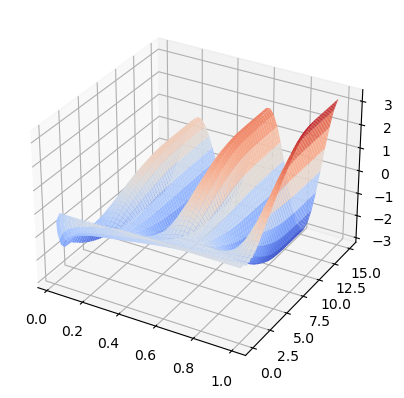

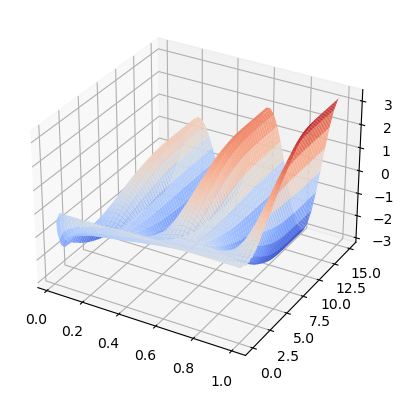

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, outTensor[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)

In [23]:
torch.save(model.state_dict(), 'deeponet2')